# Data Analysis Notebook For Hartree-Fock Stability
---

This notebook and the corresponding python file at pyfiles.HFSAnalyzer contain all data analysis and plotting scripts used in the Hatree-Fock Stability of the Homogeneous Electron Gas (HEG). The Data all comes from the executables in the src directory of the project. The logfiles are all in .json format, allowing for easy parsing, while also being human readable (except some large arrays). 

In [1]:
from imp import reload

# My modules
import sys
sys.path.append('/home/evan/git/QwikPlot/src/')
import qwikplot as qp
reload(qp)

# Python modules
import glob
import math

# 3rd party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn.apionly as sns

workdir = '/home/evan/git/HF-Stability/analysis/'
datadir = workdir + 'log'

save_dir = '/home/evan/git/HF-Stability/doc/images'
def savefig(fname,  *args, **kwargs):
    fullname = save_dir + '/' + fname
    plt.savefig(fullname, *args, **kwargs)


%matplotlib inline

## Load the Data
---

The data is parsed and collected in a pandas dataframe

In [2]:
dataframes = []
for f in glob.glob(datadir + '/*.json'):
    dataframes.append(qp.json_to_df(f, replace={'inf': 'NaN', 'nan': 'NaN'}))
df = pd.concat(dataframes, ignore_index=True)

## Ensure expected typecasts

In [3]:
df['Nk'] = df['Nk'].astype(int)
df['NDIM'] = df['NDIM'].astype(int)
df['mycase'] = df['mycase'].astype(str).str.lstrip().str.rstrip()    
df['rs'] = df['rs'].astype(float)
df['File'] = df['File'].astype(str)
df['total_calculation_time'] = df['total_calculation_time'].astype(float)
df['computation_started'] = pd.to_datetime(df['computation_started'])
df['computation_finished'] = pd.to_datetime(df['computation_finished'])
df['build_date'] = pd.to_datetime(df['build_date'].str.replace('-', ' '))
mask = df['File'].str.contains('scaling_test')
scaling_test = df[mask]
df = df[np.logical_not(mask)]

print(df.dtypes)

File                               object
NDIM                                int64
N_MV_PROD                           int64
Nexc                                int64
Nk                                  int64
Nmat                                int64
Nocc                                int64
Nvir                                int64
build_date                 datetime64[ns]
computation_finished       datetime64[ns]
computation_started        datetime64[ns]
cond_number                       float64
dav_blocksize                       int64
dav_its                             int64
dav_max_subsize                     int64
dav_maxits                          int64
dav_min_eval                      float64
dav_nconv                           int64
dav_num_evals                       int64
dav_singlet_a_minus_b             float64
dav_singlet_a_plus_b              float64
dav_time                          float64
dav_tol                           float64
dav_triplet_a_minus_b             

## Clean Data and simple calcs


In [4]:
# Remove data with critical values missing
df.dropna(axis='rows', subset=['NDIM', 'rs', 'Nk'], inplace=True)

# Of course use_delta_1D must be false for ndim=2, 3
df.loc[np.logical_or(df['NDIM'] == 2, df['NDIM'] == 3), 'use_delta_1D'] = False
df['use_delta_1D'] = df['use_delta_1D'].astype(bool)

df = df.drop_duplicates(subset=['NDIM', 'rs', 'Nk', 'mycase', 'twoE_parameter_1dCase', 'use_delta_1D'])

# The matrix was diagonalized by factoring into A + B and A - B for singlet and triplet cases
# It seems very likely that the offdiagonal components mean that these have equivalent
# eigenvalues, but I was unable to prove this definitively. To be safe, I just did all cases. 
# Thus the actual instability eigenvalue is the minimum of the eigenvalues of A + B and A - B. 
df['triplet_instability'] = df[['dav_triplet_a_minus_b', 'dav_triplet_a_plus_b']].min(axis=1)
df['singlet_instability'] = df[['dav_singlet_a_minus_b', 'dav_singlet_a_plus_b']].min(axis=1)


#df.singlet_instability.fillna(-1e9, inplace=True)
#df.triplet_instability.fillna(-1e9, inplace=True)

## Scaling Testing for 2D and 3D case

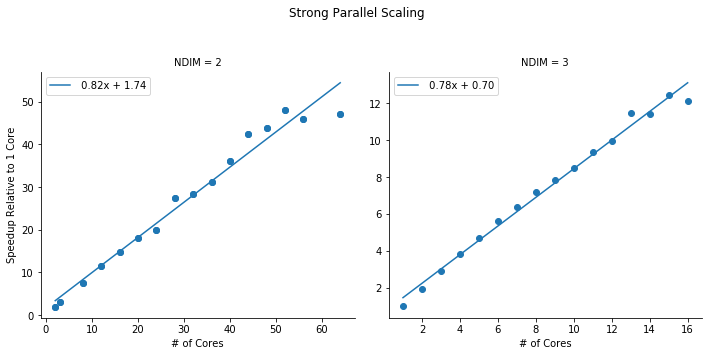

In [5]:
scaling_test['n_per_proc'] = scaling_test['Nmat'] / scaling_test['n_procs']
scaling_test['n_cores'] = scaling_test['n_procs'] // 32

scaling_test = scaling_test[scaling_test.n_cores != 60]

def add_speedup(df):
    min_row = df[df['n_cores'] == min(df['n_cores'])]
    single_core_time = np.average(min_row['total_calculation_time'] * min_row['n_cores'])
    df['Speedup'] = pd.to_numeric(single_core_time) / df['total_calculation_time']
    return df
    
scaling_test = scaling_test.groupby('NDIM').apply(add_speedup)


def linefit(x, y, **kwargs):
    """Wrapper to allow for varied scales in plots"""
    ax = plt.gca()

    plt.scatter(x, y, **kwargs)
  
    coeffs = np.polyfit(x, y, deg=1)
    poly = np.poly1d(coeffs)
    fitfunc = lambda x: poly(x)
    xvals = np.linspace(min(x), max(x), 500)
    line = plt.plot(xvals, fitfunc(xvals), label='{:5.2f}x +{:5.2f}'.format(*coeffs))
    legend = plt.legend(handles=line, loc=0)
    ax.add_artist(legend)
    

grid = sns.FacetGrid(scaling_test, col='NDIM', sharey=False, sharex=False, size=5)
grid = grid.map(linefit, 'n_cores', 'Speedup')
grid.set_axis_labels('# of Cores', 'Speedup Relative to 1 Core')
plt.suptitle('Strong Parallel Scaling')
plt.subplots_adjust(top=0.8)
plt.show()

## Analytic Energy Functions

In [6]:
def f2D(y):
    if y <= 1.0:
        #scipy and guiliani/vignale define K and E differently, x -> x*x
        return sp.ellipe(y*y)
    else:
        #scipy and guiliani/vignale define K and E differently, x -> x*x
        x = 1.0 / y
        return y * (sp.ellipe(x*x) - (1.0 - x*x) * sp.ellipk(x*x))

def f3D(y):
    if y < 10e-10:
        return 1.0
    return 0.5 + (1 - y*y) / (4*y) * math.log(abs((1+y) / (1-y)))

def analytic_exch(k, kf, ndim):
    const = -2.0 * kf / math.pi
    if ndim == 2:
        return const * f2D(k / kf)
    elif ndim == 3:
        return const * f3D(k / kf)

def analytic_energy(k, kf, ndim):
    x = np.linalg.norm(k)  #works on k of any dimension
    return (x*x / 2.0) + analytic_exch(x, kf, ndim)

## Testing Convergence of Stability Curves with # of K-points

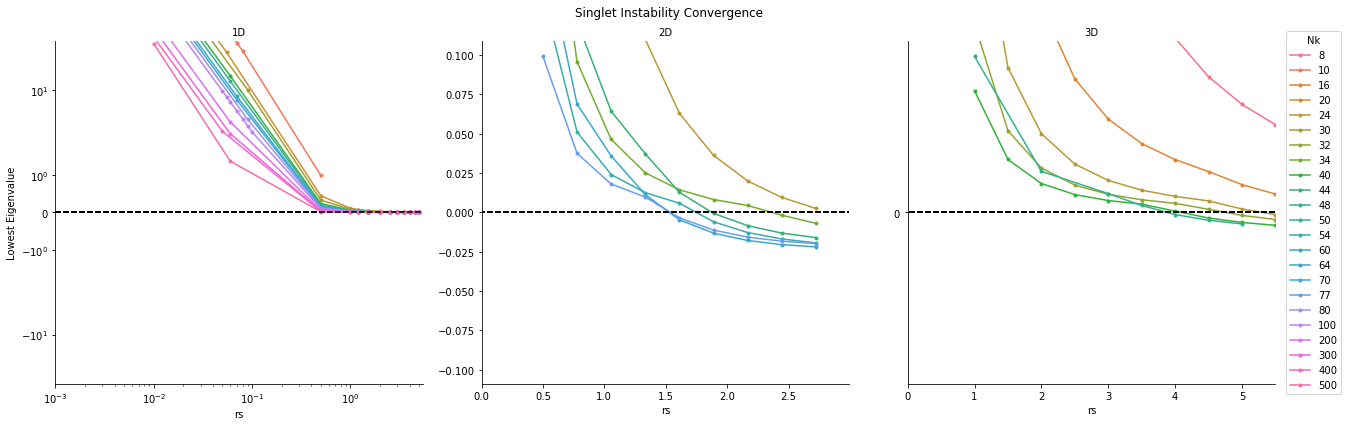

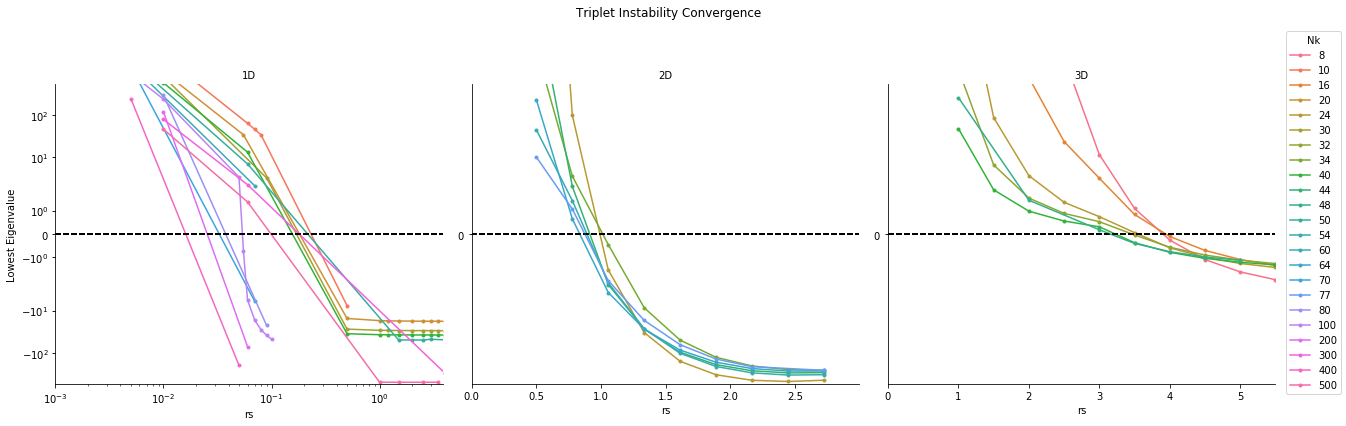

In [7]:
def plot_stability(x, y, **kwargs):
    if len(x) <= 1 or len(y) <= 1:
        return None
    x0 = np.linspace(-5, max(x) + 10, 500)
    ax = plt.gca()
    idx = np.argsort(x)

    x = np.asarray(x)[idx]
    y = np.asarray(y)[idx]
    
    
    # filled bad values with -10^9, plot the rest

    idx = np.where(y > (-10**9 + 1))
    x = x[idx]
    y = y[idx]
    sns.set_palette(sns.color_palette('Blues', len(x)))
    plt.plot(x, y, '.-',**kwargs)
    ax.plot(x0, np.zeros_like(x0), 'k--')

    ax.set_xlim(0, 1.1 * max(x))
    
    miny, maxy = min(y), max(y)
    ymag = 1.1 * max(abs(miny), abs(maxy))
    ax.set_ylim(-ymag, ymag)
    
    # For when x has some big variation for some
    std = np.std(x)
    med_diff = np.abs(np.median(np.diff(x)))
    if std / med_diff > 5.0:
        ax.set_xscale('log')
    
    # For when y has some big variation for some
    std = np.std(y)
    med_diff = np.abs(np.median(np.diff(y)))
    if std / med_diff > 10.0:
        ax.set_yscale('symlog')


grid = sns.FacetGrid(df, col='NDIM', hue='Nk', sharey=False, sharex=False, size=6)
grid = grid.map(plot_stability, 'rs', 'singlet_instability').set_titles("{col_name}D")
grid.set_axis_labels('rs', 'Lowest Eigenvalue')
grid.add_legend()
plt.suptitle('Singlet Instability Convergence')
plt.subplots_adjust(top=0.9)
plt.savefig('../doc/images/singlet-stability-convergence.pdf', format='pdf')
plt.show()


grid = sns.FacetGrid(df, col='NDIM', hue='Nk', sharey=False, sharex=False, size=6)
grid = grid.map(plot_stability, 'rs', 'triplet_instability').set_titles("{col_name}D")

grid.set_axis_labels('rs', 'Lowest Eigenvalue')
grid.add_legend()
plt.suptitle('Triplet Instability Convergence')
plt.subplots_adjust(top=0.80)
plt.savefig('../doc/images/triplet-stability-convergence.pdf', format='pdf')
plt.show()

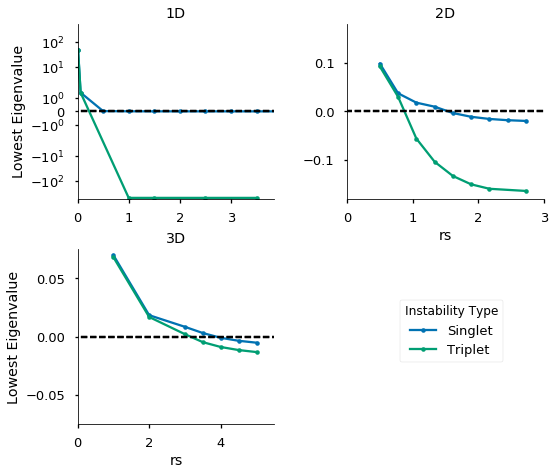

In [81]:
df2 = df.dropna(axis='rows', subset=['triplet_instability'], inplace=False).sort_values('rs')
df2 = df.fillna(-10**9)

def merge_cols(df, dest_col_name, id_name, colname_to_id):
    """Merge columns into one column, adding a new column with identifiers.
    
    This does make intermediate copies. I didn't bother to optimize."""
    
    dfs = {(colname, _id): df.copy() for colname, _id in colname_to_id.items()}
    
    cols = list(colname_to_id.keys())
    for (colname, _id), df in dfs.items():
        for name in cols:
            if name != colname:
                df.drop(name, axis=1, inplace=True)
        df[id_name] = _id
        df.rename(columns={colname: dest_col_name}, inplace=True)

    return pd.concat(dfs, ignore_index=True)


sns.set_palette('colorblind')

merged = merge_cols(df2, dest_col_name='instability', id_name='Instability Type', colname_to_id=
           {  'singlet_instability': 'Singlet'
            , 'triplet_instability': 'Triplet'
           })

gb = merged.groupby('NDIM', as_index=True)
maxes = gb.apply(lambda x: x[x['Nk'] == x['Nk'].max()])
maxes.reset_index(level=0, drop=True, inplace=True)


sns.set_context('talk')
grid = sns.FacetGrid(maxes, col='NDIM', hue='Instability Type', sharey=False, sharex=False, size=4, col_wrap=2)
grid = grid.map(plot_stability, 'rs', 'instability').set_titles("{col_name}D")
grid.set_axis_labels('rs', 'Lowest Eigenvalue')
grid.add_legend(bbox_to_anchor=(0.75, 0.25))
#plt.suptitle('Stability of RHF Solutions of the HEG')
plt.subplots_adjust(top=0.8)
plt.savefig('../doc/images/stability.pdf', format='pdf', transparent=True)
plt.show()

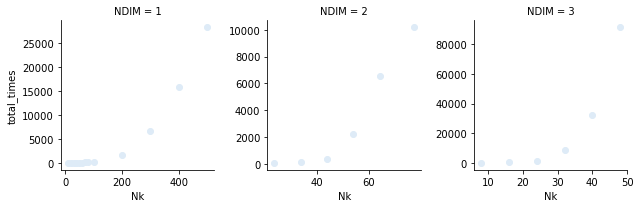

In [9]:
times = (df.groupby(['NDIM', 'Nk'])
           .apply(lambda x: x['total_calculation_time'].sum())
           .reset_index(name='total_times')
        )
g = sns.FacetGrid(times, col='NDIM', sharex=False, sharey=False)
g = g.map(plt.scatter, 'Nk', 'total_times')

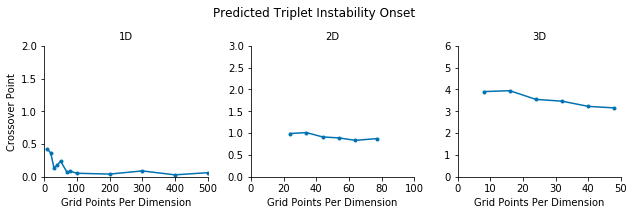

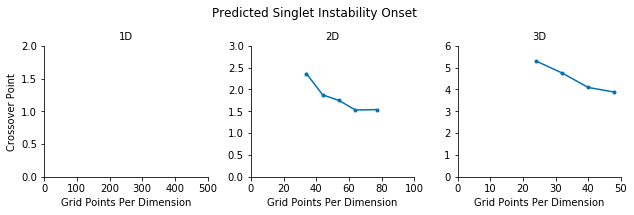

In [65]:
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

def crossover(df, x, y, interp1d_args=(), interp1d_kwargs=None, npoints=10**5, cutoff=1e-1):
    temp = df.dropna(subset=[x, y])
    x, y = temp[x], temp[y]
    
    if interp1d_kwargs is None:
        interp1d_kwargs = {}
        
    f = interp1d(x, y, *interp1d_args, **interp1d_kwargs)
    xtest = np.linspace(min(x), max(x), 100000)
    idx = np.argmin(np.abs(f(xtest)))
    xval = xtest[idx]
    yval = f(xval)
    
    if (abs(yval) < cutoff) and (xval < (max(x) - 1e-5)): 
        return xval
    else:
        return 1e10

sns.set_palette('colorblind')
temp = (df.groupby(['Nk', 'NDIM'])
        .apply(lambda d: crossover(d, 'rs', 'triplet_instability'))
        .reset_index()
        .rename(columns={0: 'Crossover'})
       )

def crossover_plot(x, y, *args, **kwargs): 
    newpoints = [i for i in zip(x, y) if i[1] < 1e9]
    try:
        xnew, ynew = zip(*newpoints)
        plt.plot(xnew, ynew, '.-', *args, **kwargs)
    except ValueError:
        plt.plot([-10], [-10], '.-', *args, **kwargs)
    if max(x) > 400:
        plt.gca().set_xlim(0, 500)
        plt.gca().set_ylim(0, 2)
    elif max(x) > 50:
        plt.gca().set_xlim(0, 100)
        plt.gca().set_ylim(0, 3)
    else:
        plt.gca().set_xlim(0, 50)
        plt.gca().set_ylim(0, 6)    

g = sns.FacetGrid(temp, col='NDIM', sharex=False, sharey=False)
g = (g.map(crossover_plot, 'Nk', 'Crossover', marker='.')
      .set_titles("{col_name}D")
      .set_axis_labels("Grid Points Per Dimension", "Crossover Point")
    )
plt.suptitle('Predicted Triplet Instability Onset')
plt.subplots_adjust(top=0.8)
savefig('triplet_onset.eps', transparent=True)
plt.show()

temp = (df.groupby(['Nk', 'NDIM'])
        .apply(lambda d: crossover(d, 'rs', 'singlet_instability'))
        .reset_index()
        .rename(columns={0: 'Crossover'})
       )

g = sns.FacetGrid(temp, col='NDIM', sharex=False, sharey=False, )
g = (g.map(crossover_plot, 'Nk', 'Crossover', marker='.')
      .set_titles("{col_name}D")
      .set_axis_labels("Grid Points Per Dimension", "Crossover Point")
    )
plt.suptitle('Predicted Singlet Instability Onset')
plt.subplots_adjust(top=0.8)
savefig('singlet_onset.eps', transparent=True)
plt.show()